# EDA / ETL Superstore

## 1. Импорт библиотек и загрузка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import json
import seaborn as sns
import numbers
import locale
import platform
from sqlalchemy import create_engine, text
from sqlalchemy.types import Date, Integer, Boolean, Float, Numeric
from dateutil.relativedelta import relativedelta

In [2]:
df = pd.read_csv("superstore_source.csv")

## 2. EDA

### 2.1 Общая информацию о датасете: пример данных, типы данных, пропуски, количество уникальных значений + количество полных дубликатов


In [3]:
df.head(1)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96


> Для удобства чтения и экономии пространства введём функцию, которая будет показывать всё это в одном выводе:

In [4]:
def dataframe_overview(df):
    # 1. Пропуски
    null_counts = df.isnull().sum()
    null_percent = (df.isnull().sum() / len(df) * 100).round(2)
    
    # 2. Типы данных
    data_types = df.dtypes

    # 3. Уникальные значения
    unique_counts = df.nunique()

    report_df = pd.DataFrame({
        'Dtype': data_types,
        'Null_Count': null_counts,
        'Null_%': null_percent,
        'Unique_Count': unique_counts,
    })

    # Общее количество строк в DataFrame
    total_rows = len(df)
    
    total_duplicates = df.duplicated().sum()
    print(f"Общее количество полных дубликатов строк в DF: {total_duplicates}\n")
    print(f"Общее количество строк в DF: {total_rows}\n")
    
    return report_df.sort_values(by='Null_Count', ascending=False)

In [5]:
dataframe_overview(df)

Общее количество полных дубликатов строк в DF: 0

Общее количество строк в DF: 9800



,Dtype,Null_Count,Null_%,Unique_Count
Postal Code,float64,11,0.11,626
Row ID,int64,0,0.00,9800
Order ID,object,0,0.00,4922
Order Date,object,0,0.00,1230
Ship Mode,object,0,0.00,4
Ship Date,object,0,0.00,1326
Customer Name,object,0,0.00,793
Segment,object,0,0.00,3
Country,object,0,0.00,1
Customer ID,object,0,0.00,793


>Видим, что пропущено 11 значений почтового индекса, не так много - выведем их:

In [6]:
df_lost_codes = df[df['Postal Code'].isna()][['Order ID','Postal Code', 'Region', 'City', 'State', 'Country']]
print(df_lost_codes)

            Order ID  Postal Code Region        City    State        Country
2234  CA-2018-104066          NaN   East  Burlington  Vermont  United States
5274  CA-2016-162887          NaN   East  Burlington  Vermont  United States
8798  US-2017-150140          NaN   East  Burlington  Vermont  United States
9146  US-2017-165505          NaN   East  Burlington  Vermont  United States
9147  US-2017-165505          NaN   East  Burlington  Vermont  United States
9148  US-2017-165505          NaN   East  Burlington  Vermont  United States
9386  US-2018-127292          NaN   East  Burlington  Vermont  United States
9387  US-2018-127292          NaN   East  Burlington  Vermont  United States
9388  US-2018-127292          NaN   East  Burlington  Vermont  United States
9389  US-2018-127292          NaN   East  Burlington  Vermont  United States
9741  CA-2016-117086          NaN   East  Burlington  Vermont  United States


>Все пропущенные индексы относятся к одному и тому же месту, а пропусков немного => можно найти вручную и вставить пропущенные значения (05401 или 05402).
Хотя (в зависимости от страны) это может быть общегородским индексом и не совсем точно указывает на адресата - такой вариант подходит, так как пропусков всего 0.11%.

**Решение**: заполнить пропущенные значения (05401).

### 2.2 Общая статистика

In [7]:
(df['Sales']<0).any()

np.False_

In [8]:
df.describe(include = 'all')

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
count,9800.000000,9800,9800,9800,9800,9800,9800,9800,9800,9800,9800,9789.000000,9800,9800,9800,9800,9800,9800.000000
unique,NaN,4922,1230,1326,4,793,793,3,1,529,49,NaN,4,1861,3,17,1849,NaN
top,NaN,CA-2018-100111,05/09/2017,26/09/2018,Standard Class,WB-21850,William Brown,Consumer,United States,New York City,California,NaN,West,OFF-PA-10001970,Office Supplies,Binders,Staple envelope,NaN
freq,NaN,14,38,34,5859,35,35,5101,9800,891,1946,NaN,3140,19,5909,1492,47,NaN
mean,4900.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55273.322403,NaN,NaN,NaN,NaN,NaN,230.769059
std,2829.160653,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32041.223413,NaN,NaN,NaN,NaN,NaN,626.651875
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1040.000000,NaN,NaN,NaN,NaN,NaN,0.444000
25%,2450.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23223.000000,NaN,NaN,NaN,NaN,NaN,17.248000
50%,4900.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58103.000000,NaN,NaN,NaN,NaN,NaN,54.490000
75%,7350.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90008.000000,NaN,NaN,NaN,NaN,NaN,210.605000


>Можно заметить, что один и тот же Product ID встречается 19 раз, а Product Name - 47: возможно есть товары с одинаковым Product Name, но разным Product ID:

In [9]:
product_id_groups = (
df.groupby('Product Name')[['Product ID','Category', 'Sales', 'Order ID']]
    .agg(lambda x: list(sorted(x.unique())))
    .reset_index()
)
product_id_groups['unique_id_count'] = product_id_groups['Product ID'].apply(len)
product_id_groups['unique_order_count'] = product_id_groups['Order ID'].apply(len)
product_id_groups['median_sales'] = product_id_groups['Sales'].apply(np.median)
product_id_dupl_names = product_id_groups[product_id_groups['unique_id_count'] > 1]

product_id_dupl_names.head(product_id_dupl_names.shape[0])

,Product Name,Product ID,Category,Sales,Order ID,unique_id_count,unique_order_count,median_sales
4,"#10- 4 1/8"" x 9 1/2"" Recycled Envelopes","[OFF-EN-10000461, OFF-EN-10000781]",[Office Supplies],"[13.984, 17.48, 26.22, 27.968, 43.7, 48.944, 5...","[CA-2015-131541, CA-2016-100573, CA-2016-10858...",2,10,27.968
259,Avery Non-Stick Binders,"[OFF-BI-10000829, OFF-BI-10004140]",[Office Supplies],"[0.898, 2.694, 3.592, 5.388, 6.286, 7.184, 10....","[CA-2015-101931, CA-2015-103492, CA-2015-11150...",2,20,8.980
537,Easy-staple paper,"[OFF-PA-10000249, OFF-PA-10000349, OFF-PA-1000...",[Office Supplies],"[9.96, 10.272, 11.952, 14.94, 16.224, 17.12, 1...","[CA-2015-111934, CA-2015-138100, CA-2015-14791...",8,44,49.120
590,Eldon Wave Desk Accessories,"[FUR-FU-10000023, FUR-FU-10003981]",[Furniture],"[4.16, 4.712, 4.992, 6.24, 7.068, 8.32, 14.136...","[CA-2015-103989, CA-2015-144414, CA-2015-14538...",2,14,8.320
941,KI Adjustable-Height Table,"[FUR-TA-10001039, FUR-TA-10004086]",[Furniture],"[51.588, 85.98, 154.764, 171.96, 206.352, 214....","[CA-2015-104283, CA-2015-117765, CA-2015-13565...",2,17,257.940
1216,Okidata C610n Printer,"[TEC-MA-10001856, TEC-MA-10003230]",[Technology],"[649.0, 1362.9]","[CA-2017-144764, CA-2018-109183]",2,2,1005.950
1248,"Peel & Seel Recycled Catalog Envelopes, Brown","[OFF-EN-10002592, OFF-EN-10003448]",[Office Supplies],"[23.16, 27.792, 34.74, 55.584, 57.9, 64.848]","[CA-2015-140396, CA-2017-157742, CA-2018-14234...",2,6,45.162
1296,Prang Drawing Pencil Set,"[OFF-AR-10002766, OFF-AR-10003251]",[Office Supplies],"[2.224, 4.448, 5.56, 6.672, 8.34, 13.9, 20.016]","[CA-2015-113271, CA-2016-103723, CA-2016-15530...",2,11,6.672
1492,Staple envelope,"[OFF-EN-10001028, OFF-EN-10001099, OFF-EN-1000...",[Office Supplies],"[4.464, 7.824, 8.928, 9.344, 9.78, 11.36, 13.3...","[CA-2015-107524, CA-2015-107573, CA-2015-11392...",9,47,28.400
1493,Staple holder,"[OFF-AP-10001366, OFF-AP-10002222, OFF-AP-1000...",[Office Supplies],"[2.394, 8.67, 10.98, 17.34, 20.808, 35.91, 43....","[CA-2015-101147, CA-2015-127523, CA-2015-13370...",3,13,35.910


>Найдено 16 повторяющихся значений, в основном - канцелярия, которую вероятно небрежно занесли в датасет. Есть несколько строк из категории "Мебель", но по названию видно, что это также какие-то небольшие товары. Из крупных товаров только принтер: Okidata C610n Printer.
>1. Product ID для каждого из товаров имеют одинаковый префикс + одинаковую категорию товара (префикс часто формируется из названия категории).
>2. Продажи (Sales) находятся в близком диапазоне значений, медианные значения это подтверждают.
>3. (дополнительно) Количество уникальных заказов (Order ID), в которых фигурируют данные товары - велико => то есть это чаще всего это не позиции одного заказа. Если было бы иначе - можно было бы предположить, что клиент в одном заказе взял несколько разных товаров, поэтому их занесли с разными Product ID.

**Решение**: объединить эти товары, оставив какой-то один из Product ID.


### 2.3 Проверка неконсистентности по именам покупателей
> Могут быть случаи, когда имена клиентов совпали. Это не так критично, так как есть id клиента, но проверить стоит.

In [10]:
df_customers_grouped = df.groupby('Customer ID').nunique()
df_customers_grouped[df_customers_grouped['Customer Name']>1]

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
Customer ID,,,,,,,,,,,,,,,,,


### 2.4 Обзорный анализ продаж

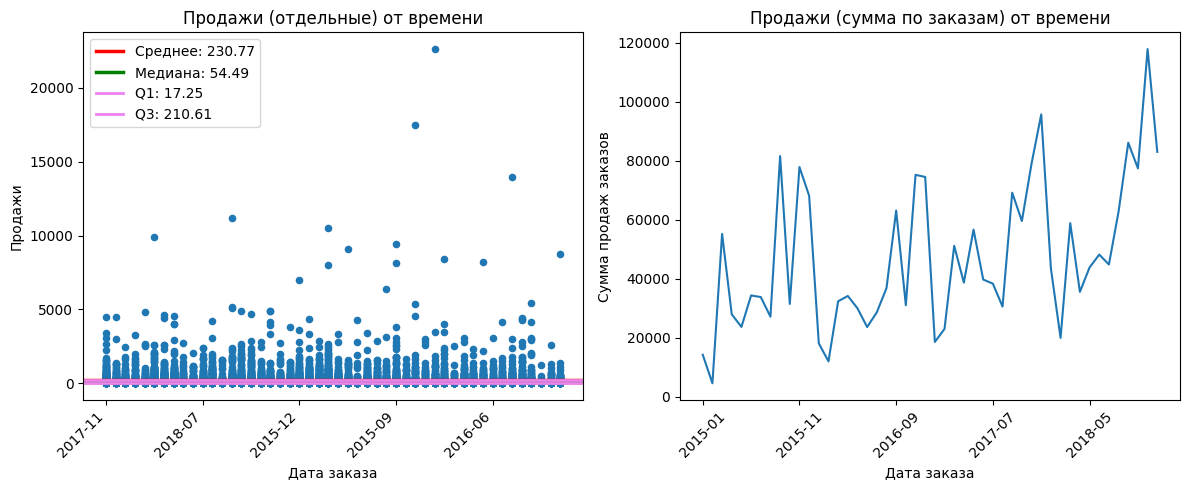

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

df['Order Date'] = pd.to_datetime(df['Order Date'], format = '%d/%m/%Y')
df['Ship Date'] = pd.to_datetime(df['Ship Date'], format = '%d/%m/%Y')
#Scatter-график отдельных продаж по времени
mean_sales = df['Sales'].mean()
median_sales = df['Sales'].median()
q1_sales = df['Sales'].quantile(0.25)
q3_sales = df['Sales'].quantile(0.75)

#Среднее
axes[0].axhline(mean_sales, color='red', linestyle='-', linewidth=2.5, 
           label=f'Среднее: {mean_sales :.2f}')

#Медиана
axes[0].axhline(median_sales, color='green', linestyle='-', linewidth=2.5, 
           label=f'Медиана: {median_sales :.2f}')

#1-й квартиль
axes[0].axhline(q1_sales, color='violet', linestyle='-', linewidth=2, 
           label=f'Q1: {q1_sales :.2f}')

#3-й квартиль
axes[0].axhline(q3_sales, color='violet', linestyle='-', linewidth=2, 
           label=f'Q3: {q3_sales :.2f}')
axes[0].legend()

df['order_month_year'] = df['Order Date'].dt.strftime('%Y-%m')
df.plot(kind='scatter', y='Sales', x='order_month_year', ax=axes[0], xlabel='Дата заказа', ylabel = 'Продажи', title = 'Продажи (отдельные) от времени')
xticks = df['order_month_year'].unique()[::10]
axes[0].set_xticks(xticks)
axes[0].set_xticklabels(xticks, rotation=45, ha='right')

#График суммарных продаж по времени
sales_by_orderdate = df.groupby('order_month_year')['Sales'].sum()
sales_by_orderdate.plot(xlabel='Дата заказа', ylabel='Сумма продаж заказов', ax=axes[1], title = 'Продажи (сумма по заказам) от времени')
axes[1].tick_params(axis='x', rotation=45)
axes[0].legend()
plt.tight_layout()
plt.show()

>Посмотрим на большие покупки (больше 10000). Скорее всего - какая-то офисная техника, которую покупают разово:

In [12]:
df[df['Sales']>10000]

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,order_month_year
2623,2624,CA-2018-127180,2018-10-22,2018-10-24,First Class,TA-21385,Tom Ashbrook,Home Office,United States,New York City,New York,10024.0,East,TEC-CO-10004722,Technology,Copiers,Canon imageCLASS 2200 Advanced Copier,11199.968,2018-10
2697,2698,CA-2015-145317,2015-03-18,2015-03-23,Standard Class,SM-20320,Sean Miller,Home Office,United States,Jacksonville,Florida,32216.0,South,TEC-MA-10002412,Technology,Machines,Cisco TelePresence System EX90 Videoconferenci...,22638.480,2015-03
4190,4191,CA-2018-166709,2018-11-17,2018-11-22,Standard Class,HL-15040,Hunter Lopez,Consumer,United States,Newark,Delaware,19711.0,East,TEC-CO-10004722,Technology,Copiers,Canon imageCLASS 2200 Advanced Copier,10499.970,2018-11
6826,6827,CA-2017-118689,2017-10-02,2017-10-09,Standard Class,TC-20980,Tamara Chand,Corporate,United States,Lafayette,Indiana,47905.0,Central,TEC-CO-10004722,Technology,Copiers,Canon imageCLASS 2200 Advanced Copier,17499.950,2017-10
8153,8154,CA-2018-140151,2018-03-23,2018-03-25,First Class,RB-19360,Raymond Buch,Consumer,United States,Seattle,Washington,98115.0,West,TEC-CO-10004722,Technology,Copiers,Canon imageCLASS 2200 Advanced Copier,13999.960,2018-03


> Оценим сколько % от общих продаж за всё время составляют такие дни (где сумма заказов больше 5000 и 10000 за всю историю наблюдений):
> 

In [13]:
df_big_sales = df[df['Sales']>10000]
df_half_big_sales = df[df['Sales']>5000]
df_second_big_sales = df[df['Sales']>800]
df_q3_sales = df[df['Sales']>q3_sales]
print('Процент покупок от 10000: ', df_big_sales['Sales'].sum()/df['Sales'].sum()*100)
print('Процент покупок от 5000: ', df_half_big_sales['Sales'].sum()/df['Sales'].sum()*100)
print('Процент покупок от 800: ', df_second_big_sales['Sales'].sum()/df['Sales'].sum()*100)
print('Процент покупок от Q3: ', df_q3_sales['Sales'].sum()/df['Sales'].sum()*100)

Процент покупок от 10000:  3.3533979451556055
Процент покупок от 5000:  7.970737304780427
Процент покупок от 800:  50.500889480845665
Процент покупок от Q3:  83.29746621458742


> Видно, что половину дохода составляют крупные заказы (от 800 долларов), а если считать от Q3 - то 83.3%

**Рекомендация**: оценить возможности улучшения работы с оптовыми клиентами или юридическими лицами (например какие-то оффлайн мероприятия, прямые контакты).

В 2.2 было видно, в что одну из дат купили 38 товаров. Надо посмотреть, насколько это значение необычно, по сравнению с другими заказами:

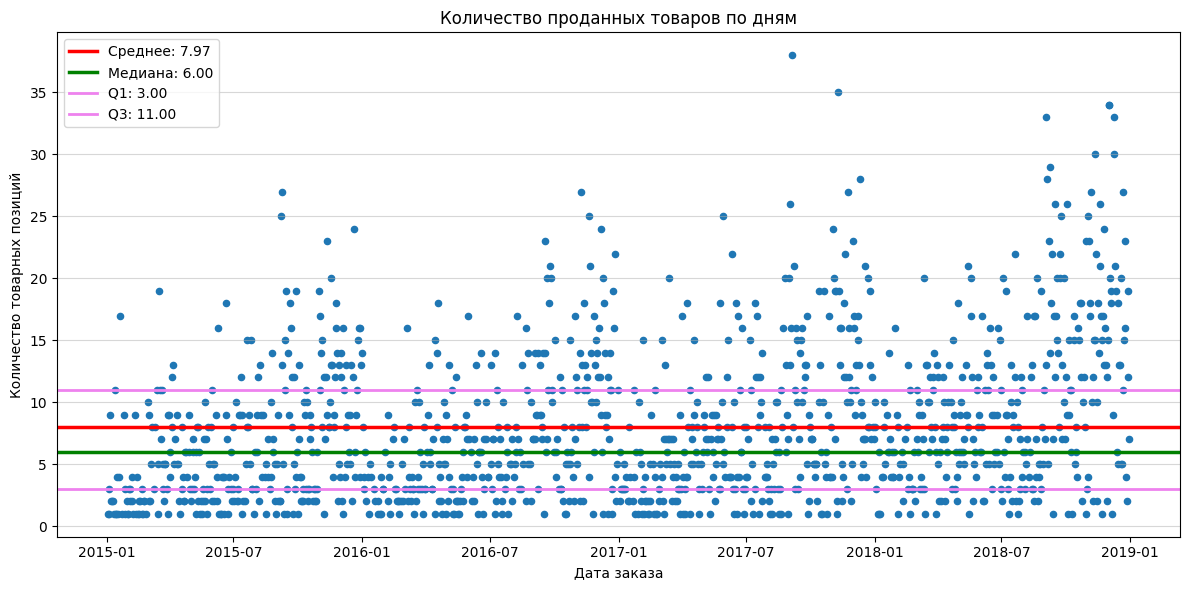

In [14]:
df_freq_dates = df.groupby(['Order Date'])['Product ID'].count().reset_index()

mean_freq_dates = df_freq_dates['Product ID'].mean()
median_freq_dates = df_freq_dates['Product ID'].median()
q1_freq_dates = df_freq_dates['Product ID'].quantile(0.25)
q3_freq_dates = df_freq_dates['Product ID'].quantile(0.75)

fig, ax = plt.subplots(1,1,figsize=(12, 6))
df_freq_dates.plot(kind = 'scatter', x = 'Order Date', y = 'Product ID',
                   ax = ax, xlabel = 'Дата заказа', ylabel = 'Количество товарных позиций', 
                   title = 'Количество проданных товаров по дням')
# Среднее значение (Mean)
ax.axhline(mean_freq_dates, color='red', linestyle='-', linewidth=2.5, 
           label=f'Среднее: {mean_freq_dates:.2f}')

# Медиана (Median)
ax.axhline(median_freq_dates, color='green', linestyle='-', linewidth=2.5, 
           label=f'Медиана: {median_freq_dates:.2f}')

# 1-й квартиль (Q1)
ax.axhline(q1_freq_dates, color='violet', linestyle='-', linewidth=2, 
           label=f'Q1: {q1_freq_dates:.2f}')

# 3-й квартиль (Q3)
ax.axhline(q3_freq_dates, color='violet', linestyle='-', linewidth=2, 
           label=f'Q3: {q3_freq_dates:.2f}')
ax.legend()

plt.grid(True, axis='y', linestyle='-', alpha=0.5)
plt.tight_layout()
plt.show()

>Есть несколько областей с выбросами (выглядят как всплески некоторой толщины): с июля по январь каждого года. Предположение: скорее всего это канцелярские товары и мебель, так как начинается учебный год, а бизнес выходит из отпусков.

**Предположение:** спрос - сезонный и стоит подстроить стратегию маркетинга с учётом сезонности.

Дополнительно оценим сколько % от общих продаж за всё время составляют такие дни (где количество заказов больше Q3 за всю историю наблюдений).

In [15]:
mask_big_orders = df_freq_dates[df_freq_dates['Product ID']>q3_freq_dates]
df_big_orders = pd.merge(mask_big_orders['Order Date'], df, how = 'inner', on = 'Order Date')

In [16]:
print(100*df_big_orders['Sales'].sum()/df['Sales'].sum())

51.85787188036966


> Видно, что сумма таких заказов даёт больше половины продаж магазина.

**Рекомендация**: усилить внимание маркетинга на сезонности - возможно получится поднять амплитуду всплесков ещё выше.

### 2.5 Когортный анализ
Сгруппируем клиентов по кварталу их первой покупки (когорте) и отследим их поведение на протяжении всего жизненного цикла. Это позволяет отделить влияние времени, прошедшего с момента привлечения, от общих рыночных или сезонных факторов.

#### 2.5.1 Удержание

Анализ коэффициента удержания показывает, насколько хорошо бизнес удерживает клиентов, привлечённых в разные периоды. Мы используем его для диагностики в воронки лояльности.

Здесь мы анализируем:
-  Насколько лояльно ядро клиентов? Как долго клиенты 2015−2016 годов продолжают возвращаться?
-  Где происходит отток? В каком квартале (индекс 1, 2, 3) большинство когорт теряет наибольший процент клиентов?
-  Как качество привлечения менялось со временем? Удерживаются ли новые когорты лучше или хуже старых, и какой риск это несёт для будущей стабильности продаж?

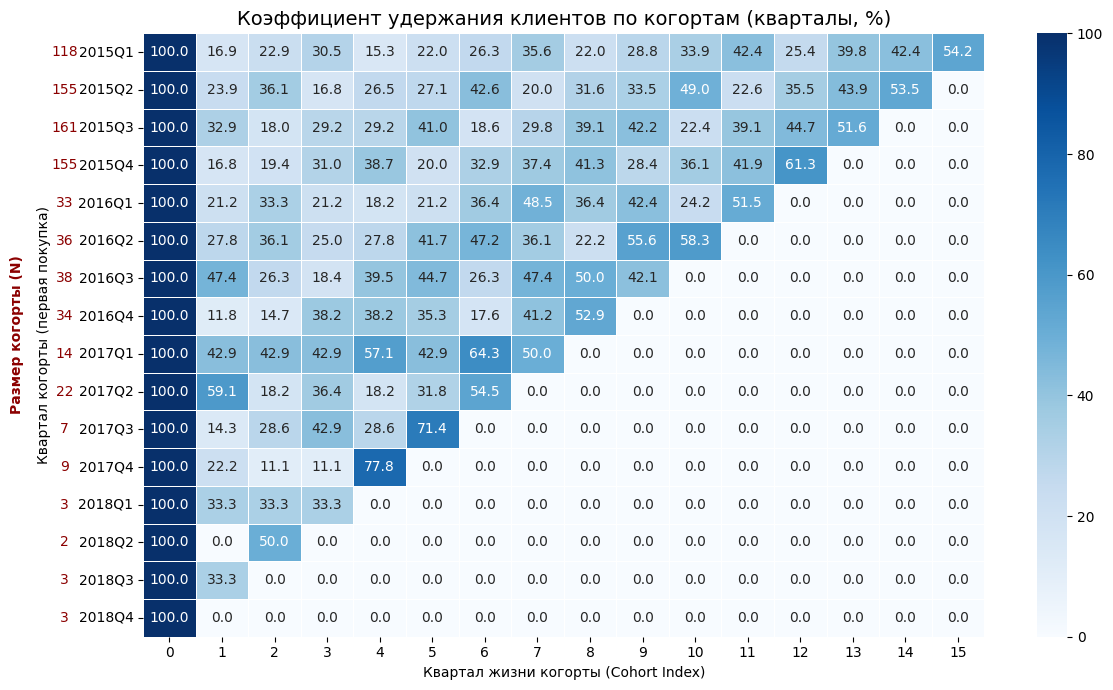

Данные с:  2015-01-03 00:00:00  по  2018-12-30 00:00:00


In [17]:
df['Order Quarter'] = df['Order Date'].dt.to_period('Q') 
df['Cohort Quarter'] = df.groupby('Customer ID')['Order Date'].transform('min').dt.to_period('Q') # когорты - квартал первой покупки клиента
df['Cohort Index'] = df['Order Quarter'].astype(int) - df['Cohort Quarter'].astype(int) #разница между кварталом текущего заказа и кварталом первой покупки.

cohort_counts = df.pivot_table(
        index='Cohort Quarter',
        columns='Cohort Index',
        values='Customer ID',
        aggfunc='nunique',
        fill_value=0
    )
cohort_counts = cohort_counts.reindex(sorted(cohort_counts.columns), axis=1)
cohort_sizes = cohort_counts[0] #размер каждой когорты
retention_matrix = cohort_counts.divide(cohort_sizes, axis=0) * 100

fig, ax = plt.subplots(figsize=(12, 7))
sns.heatmap(retention_matrix.round(1), annot=True, fmt='.1f', cmap='Blues', cbar=True,
            linewidths=0.5, linecolor='white', ax=ax)

#доп. подписи слева: размер когорты
for ytick, cohort_size in zip(ax.get_yticks(), cohort_sizes):
    ax.text(-1.5, ytick + 0, str(cohort_size), color='darkred', fontsize=10,
            verticalalignment='center', horizontalalignment='center')
ax.text(-0.15, 0.5, # Позиция
        'Размер когорты (N)',
        color='darkred',
        fontsize=10,
        verticalalignment='center',
        horizontalalignment='center',
        transform=ax.transAxes, # координаты в относительных единицах
        fontweight='bold', rotation = 90)

ax.set_title('Коэффициент удержания клиентов по когортам (кварталы, %)', fontsize=14)
ax.set_ylabel('Квартал когорты (первая покупка)', labelpad=20)
ax.set_xlabel('Квартал жизни когорты (Cohort Index)')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.show()

min_date = (df['Order Date'].min()) 
max_date = (df['Order Date'].max())
print('Данные с: ',min_date, ' по ',max_date)

Анализ охватывает 16 кварталов (с 2015Q1 по 2018Q4). Этого достаточно для выявления долгосрочных трендов и сезонности. Матрица имеет правильную треугольную структуру: данные обрываются после 2018Q4, поэтому когорты, привлеченные позже (например, 2018Q1), не имеют данных о возвратах в 2019 году (Индексы 4 и выше).

**Метрика**: коэффициент удержания (Retention Rate) - процент клиентов из исходной когорты, которые вернулись и совершили покупку в заданном квартале жизни.

**Ключевые инсайты**
1. *Резкое падение* новых клиентов (**падение на 77% за один год**), привлекаемых каждый квартал, при этом продажи растут (см. график продаж выше). В начале (2015) быстрое занятие рынка, особенно это касается B2B: офисы и фрилансеры, активно ищущие поставщика, нашли магазин, закупились и теперь лишь докупают необходимое (2016). В 2017-2018 происходит "насыщение" и выход на плато: все офисы в округе уже являются постоянными клиентами - это видно из долгосрочного удержания. *Продажи растут*, однако появляется **чрезмерная зависимость** от старого ядра клиентов. **Риск:** если одна из крупных когорт решит уйти - рост продаж резко упадёт.  
**Решение:** срочно нужен приток "свежей крови" - нужно привлечь новых клиентов: (a) оценить географию и понять - насыщен ли рынок; если да - расширять гео, (b) если нет - оценить CAC, понять, что изменилось в 2016 году.

3. Долгосрочное удержание (хвост): поведение когорт после года (индекс 4) выглядит хорошо, имеет тенденцию к усилению со временем. При этом удержание старых когорт (2015 год) стабильно и даже растет. (**a**) *Возможной причиной можно назвать универсальность ассортимента магазина, а также привычность (интертность) людей к постоянному месту покупки*. (**b**) *Ещё одной причиной может быть срок службы товара - так как ассортимент состоит либо из долговечных товаров (мебель, электроника), либо из мелких товаров больших объемов (карточки, скрепки и т.д.)*.  
**Рекомендация 1**: исследовать срок службы сложных товаров.  
**Рекомендация 2**: оценить среднее время расходования мелких товаров, покупаемых в большом объёме и изменить количество заказов данного товара (провести опрос).
4. Новые когорты тоже демонстрируют сильное удержание, часто превышая 40%.
5. Первые три квартала жизни клиента демонстрируют значительную волатильность: (a) когорты 2015-2016 теряют значительную  часть клиентов (-16%, -36%), (b) когорты 2017 года показывают более сильное удержание в первые три квартала (2017Q3: 14.3% -> 28.6% -> *71.4%*), однако количество клиентов в них очень низкое.  
   **Рекомендация 3**: исследовать опыт маркетинговых кампаний в данные периоды, сопоставить с сезонностью покупок. Если опыт положительный - повторить кампании.
6. Последние когорты, по которым нет полного цикла наблюдений, выглядят слабо, что может быть как реальной проблемой, так и артефактом. В данном случае подтверждается проблема отсутствия новых клиентов.

**Вывод**: матрица демонстрирует высокую степень лояльности старых когорт, а также волатильность и реактивность в новых, косвенно подтверждая необходимость сфокусироваться на сезонности продаж, есть возможность оптимизации ассортимента (см. рекомендацию 2). Критически важно сфокусироваться на привлечении новых клиентов, чтобы снизить зависимость от старых когорт.

#### 2.5.2 LTV накопительный

Анализ накопительного LTV позволяет измерить, сколько денег в среднем приносит клиент каждой когорты за весь период сотрудничества.

Здесь анализируем:

-  Кто является самым ценным клиентом? Какие когорты (годы привлечения) принесли самую высокую выручку за четыре года?
-  Как быстро окупается клиент? Какова скорость роста LTV в первые 1−2 года жизни когорты?
-  Каково реальное влияние падения привлечения? Насколько сильно LTV последних когорт (2017−2018) отличается от LTV старых, и каков финансовый ущерб от привлечения менее ценных клиентов?
-  Где заканчивается рост? В какой момент LTV перестает расти, указывая на то, что потенциал перекрестных продаж (cross-sell) исчерпан?

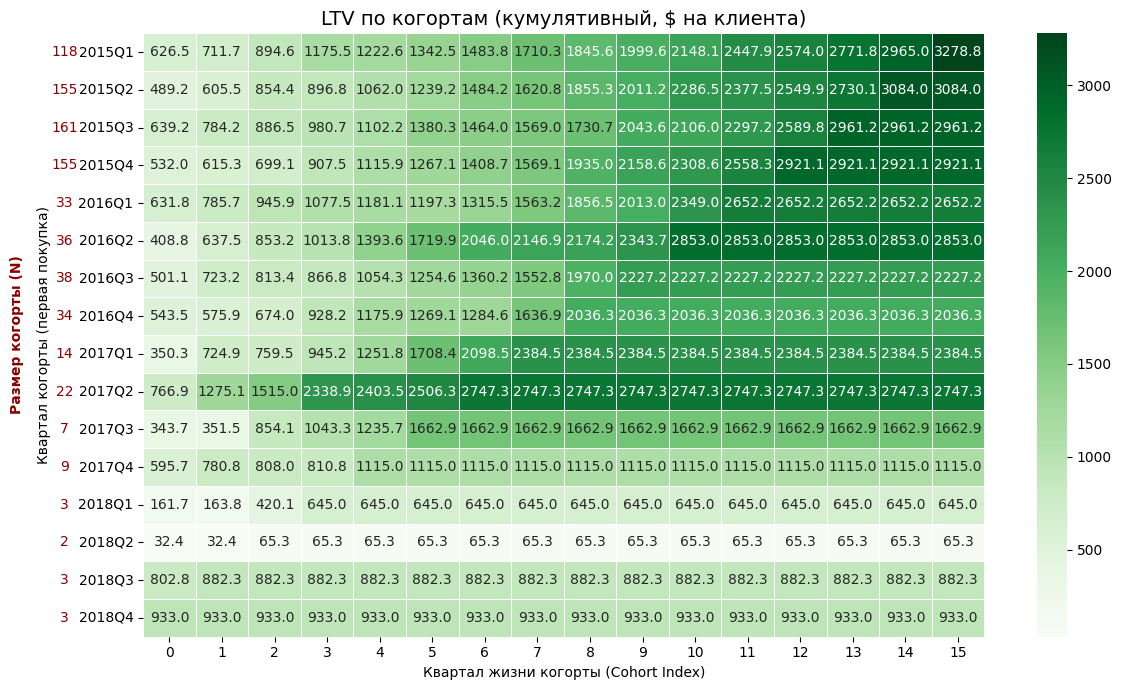

Данные с: 2015-01-03 00:00:00 по 2018-12-30 00:00:00


In [18]:
#LTV-матрица
#Общие продажи по каждой когорте и кварталу жизни
cohort_sales = df.pivot_table(
    index='Cohort Quarter',
    columns='Cohort Index',
    values='Sales',
    aggfunc='sum',
    fill_value=0
)

#В среднем на одного клиента из когорты - LTV
ltv_matrix = cohort_sales.divide(cohort_sizes, axis=0)

#Кумулятивный LTV по кварталам жизни когорты
ltv_cumulative = ltv_matrix.cumsum(axis=1)

fig, ax = plt.subplots(figsize=(12, 7))
sns.heatmap(ltv_cumulative.round(1), annot=True, fmt='.1f', cmap='Greens', cbar=True,
            linewidths=0.5, linecolor='white', ax = ax)
#доп. подписи слева: размер когорты
for ytick, cohort_size in zip(ax.get_yticks(), cohort_sizes):
    ax.text(-1.5, ytick + 0, str(cohort_size), color='darkred', fontsize=10,
            verticalalignment='center', horizontalalignment='center')

ax.text(-0.15, 0.5, # Позиция
        'Размер когорты (N)',
        color='darkred',
        fontsize=10,
        verticalalignment='center',
        horizontalalignment='center',
        transform=ax.transAxes, # координаты в относительных единицах
        fontweight='bold', rotation = 90)

ax.set_title('LTV по когортам (кумулятивный, $ на клиента)', fontsize=14)
ax.set_ylabel('Квартал когорты (первая покупка)', labelpad=20)
ax.set_xlabel('Квартал жизни когорты (Cohort Index)')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.show()

print('Данные с:', min_date, 'по', max_date)

Матрица LTV подтверждает переход бизнеса в состояние высокой финансовой зависимости от старых, высокодоходных клиентов.

**Ключевые инсайты**:
1. Исключительная лояльность старых когорт: когорты 2015-2016 являются абсолютным ядром, которое наращивает средний чек. Высокая концентрация выручки в 4 когортах (примерно 600 клиентов) является **огромным риском**: уход даже 10% из них окажет более сильное влияние, чем полное исчезновение когорт 2017-2018.
2. Очень слабая когорта 2018Q2: большинство усилий по привлечению в этот квартал оказались неэффективны.
3. 2017Q2: быстрый рост LTV с 766\\$ до 2747\\$ к индексу 3, а затем остановка роста: значит были разовые крупные заказы, а затем клиент стал "спящим". Это также тревожная тенденция.

**Рекомендация**: нужно не просто привлечь новых клиентов. Также необходимо, чтобы эти новые клиенты покупали не только крупные товары с большим сроком службы, но и расходные материалы. Разовые покупки не обеспечивают стабильность. Нужно нарастить продажи расходных материалов.

### 2.6 RFM
После когортного анализа стало видно, что существует выраженная зависимость от старых когорт клиентов, а в новых когортах наблюдается резкое падение удержания.  
Чтобы глубже понять структуру клиентской базы и выявить ключевые сегменты, проведём **RFM-анализ**.

RFM-анализ позволяет классифицировать клиентов по трём показателям:

- **R (Recency)** - давность последней покупки (в днях относительно даты среза).  
- **F (Frequency)** - частота покупок (количество заказов за весь период).  
- **M (Monetary)** - суммарная выручка от клиента.

Основные вопросы:
- Кто т.н. "чемпионы" - самые активные и прибыльные клиенты?  
- Кто находится в группе риска — ранее лояльные клиенты, которые давно не покупали и могут уйти?  
- Какие сегменты требуют реактивации или поддержки?
- Какие группы клиентов формируют основу выручки?

#### 2.6.1 RFM - основная часть

In [19]:
#Дата последней покупки в датасете (R)
snapshot_date = df['Order Date'].max() + pd.Timedelta(days=1)
print("Считаем Recency относительно:", snapshot_date)

#Группировка по клиентам для расчета RFM
rfm = df.groupby('Customer ID').agg({
    'Order Date': lambda x: (snapshot_date - x.max()).days, # R
    'Order ID': 'nunique',                                  # F
    'Sales': 'sum'                                          # M
}).reset_index()

rfm.rename(columns={
    'Order Date': 'Recency',
    'Order ID': 'Frequency',
    'Sales': 'Monetary'
}, inplace=True)
rfm = rfm[rfm['Monetary'] > 0]

#Расчет квантилей для сегментации
quantiles = rfm[['Recency', 'Frequency', 'Monetary']].quantile([0.25, 0.5, 0.75]).to_dict()

def r_score(x, q):
    if x <= q[0.25]:
        return 4
    elif x <= q[0.5]:
        return 3
    elif x <= q[0.75]:
        return 2
    else:
        return 1

def fm_score(x, q):
    if x <= q[0.25]:
        return 1
    elif x <= q[0.5]:
        return 2
    elif x <= q[0.75]:
        return 3
    else:
        return 4

#Рейтинг R, F, M
rfm['R_Score'] = rfm['Recency'].apply(lambda x: r_score(x, quantiles['Recency']))
rfm['F_Score'] = rfm['Frequency'].apply(lambda x: fm_score(x, quantiles['Frequency']))
rfm['M_Score'] = rfm['Monetary'].apply(lambda x: fm_score(x, quantiles['Monetary']))

#Составляем общий RFM рейтинг
rfm['RFM_Score'] = rfm['R_Score'].map(str) + rfm['F_Score'].map(str) + rfm['M_Score'].map(str)

#Определяем сегменты
def rfm_segment(row):
    if row['R_Score'] == 4 and row['F_Score'] == 4:
        return 'Чемпионы'
    elif row['R_Score'] >= 3 and row['F_Score'] >= 3:
        return 'Лояльные'
    elif row['R_Score'] == 1 and row['F_Score'] <= 2:
        return 'Риск'
    else:
        return 'Прочие'
rfm['Segment'] = rfm.apply(rfm_segment, axis=1)

rfm = rfm.rename(columns = {
    'Recency': 'R (давность)',
    'Frequency': 'F (частота)',
    'Monetary': 'M (ценность)',
    
    'R_Score': 'Балл R',
    'F_Score': 'Балл F',
    'M_Score': 'Балл M',
    
    'RFM_Score': 'Индекс RFM',
    'Segment': 'Сегмент RFM'
})

#Сортировка будет по заданному порядку категорий
segment_order = ['Риск','Чемпионы', 'Лояльные', 'Прочие']
rfm['Сегмент RFM'] = pd.Categorical(
    rfm['Сегмент RFM'],
    categories=segment_order,
    ordered=True
)
rfm = rfm.sort_values(['Сегмент RFM', 'Индекс RFM'], ascending=[True, False])

#Старые "чемпионы" под угрозой оттока
old_champions_at_risk = rfm[(rfm['Сегмент RFM'] == 'Чемпионы') & (rfm['Балл R'] <= 2)]

print("RFM-анализ по клиентам:")
display(rfm.head(10))
print("\nСтарые \"чемпионы\" под угрозой оттока:")
print(old_champions_at_risk)

Считаем Recency относительно: 2018-12-31 00:00:00
RFM-анализ по клиентам:


,Customer ID,R (давность),F (частота),M (ценность),Балл R,Балл F,Балл M,Индекс RFM,Сегмент RFM
104,BS-11365,559,5,10501.653,1,2,4,124,Риск
240,DW-13480,218,5,5271.628,1,2,4,124,Риск
407,JS-15880,535,5,3868.020,1,2,4,124,Риск
422,KD-16270,485,5,8282.358,1,2,4,124,Риск
487,MC-17425,400,5,4432.138,1,2,4,124,Риск
643,RH-19510,468,6,6979.180,1,2,4,124,Риск
665,SB-20185,189,6,6410.996,1,2,4,124,Риск
737,TB-21400,203,6,9108.742,1,2,4,124,Риск
741,TC-20980,400,5,19052.218,1,2,4,124,Риск
776,VD-21670,582,6,6442.254,1,2,4,124,Риск



Старые "чемпионы" под угрозой оттока:
Empty DataFrame
Columns: [Customer ID, R (давность), F (частота), M (ценность), Балл R, Балл F, Балл M, Индекс RFM, Сегмент RFM]
Index: []




**Ключевые инсайты**
- В сегменте "чемпионов" в текущем периоде нет клиентов - это указывает на отсутствие активных покупателей с высокой частотой и давностью в верхнем квартиле.  
- Основная группа ценных клиентов сосредоточена в сегменте "Риск" — это клиенты с высокой исторической ценностью (высокие F и M), но с очень низким R (400–580+ дней без покупок).  
- Эти клиенты когда-то формировали значительную часть выручки, но сейчас находятся в зоне риска потери.  
- Новых "чемпионов" не появилось, что согласуется с результатами когортного анализа: новые когорты малочисленны и не формируют стабильной клиентской базы.

**Рекомендация 1:** сегмент "At Risk" с высокими M и F — приоритетная аудитория для реактивационных кампаний. Цель — вернуть старых лояльных клиентов с помощью персональных предложений, скидок или триггерных коммуникаций. Одновременно стоит проанализировать новые когорты, чтобы понять, почему не формируются новые чемпионы.  
**Рекомендация 2**: рассмотреть B2B рынок / сегмент рынка, где оборудование портится в силу производственных условий и попробовать предложить им товар с высокой стоимостью за единицу. 

#### 2.6.2 Гистограммы (дополнительно)
Дополнительно построим гистограммы, отображающие продажи по категориям, чтобы убедиться в правильности предыдущих выводов.

In [20]:
df.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'order_month_year', 'Order Quarter',
       'Cohort Quarter', 'Cohort Index'],
      dtype='object')

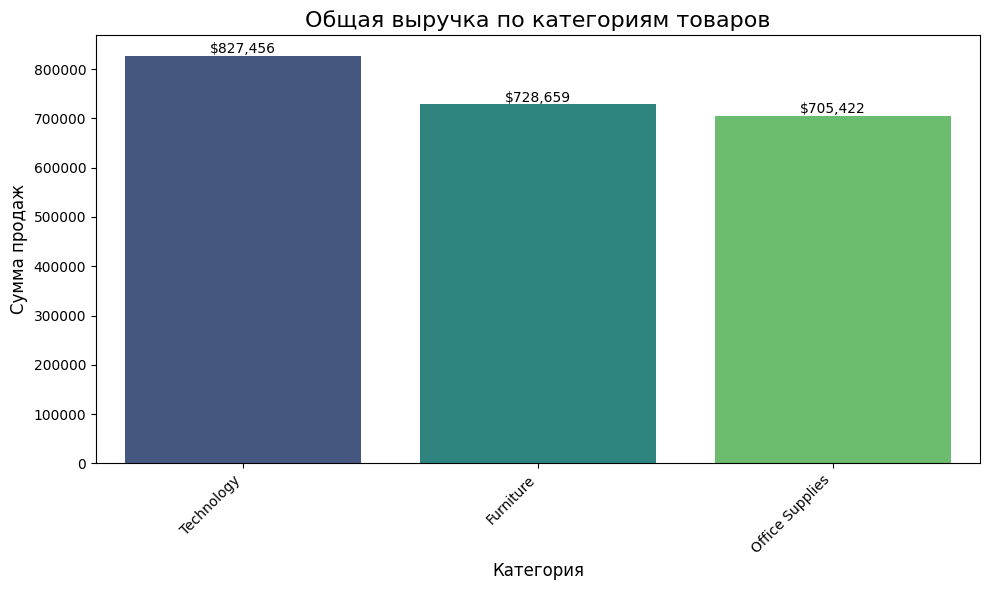

In [21]:
df_hist = df.groupby('Category')['Sales'].sum().sort_values(ascending=False).reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_hist,
    x='Category',       
    y='Sales',           
    hue='Category',      
    palette='viridis',
    legend=False
)
plt.title('Общая выручка по категориям товаров', fontsize=16)
plt.xlabel('Категория', fontsize=12)
plt.ylabel('Сумма продаж', fontsize=12)
plt.xticks(rotation=45, ha='right') 
for index, value in enumerate(df_hist['Sales'].values):
    plt.text(index, value + 5000, f'${value:,.0f}', ha='center', fontsize=10)
plt.tight_layout()
plt.show()

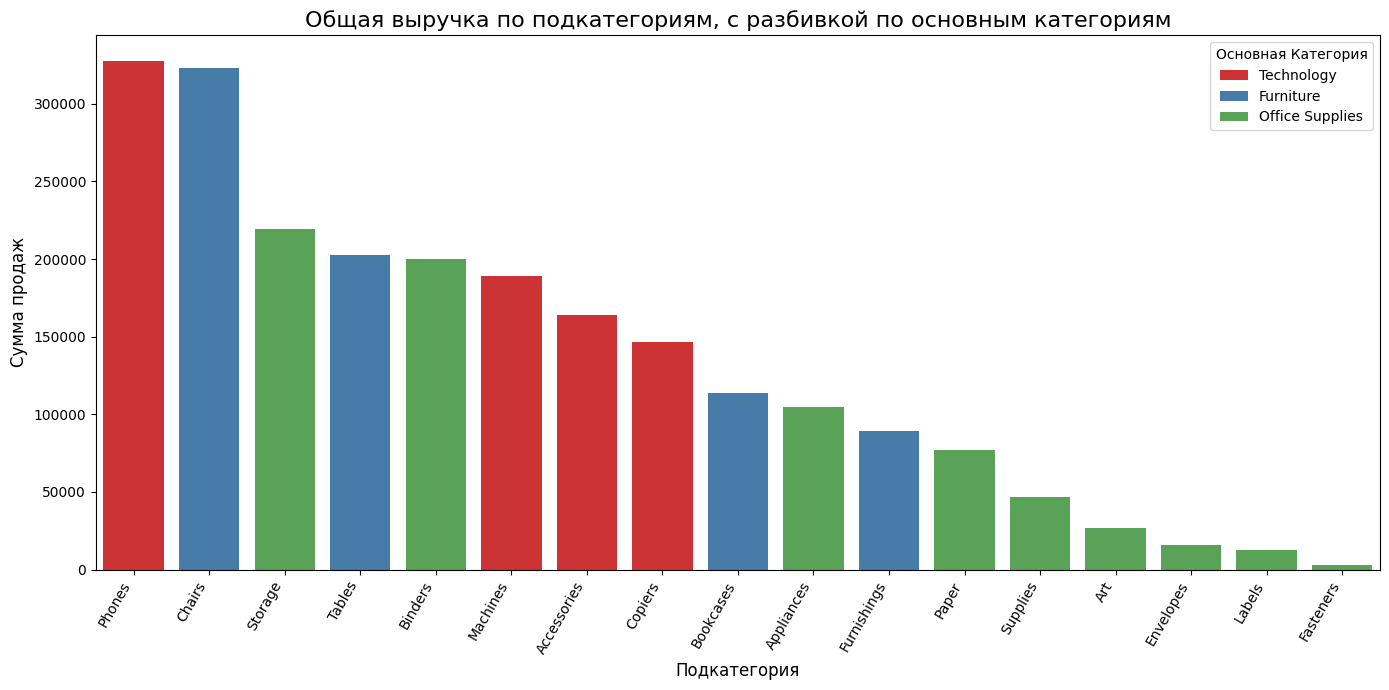

In [22]:
df_subcat_hist = df.groupby(['Category', 'Sub-Category'])['Sales'].sum().reset_index()
df_subcat_hist = df_subcat_hist.sort_values(by='Sales', ascending=False)
plt.figure(figsize=(14, 7))
sns.barplot(
    data=df_subcat_hist,
    x='Sub-Category',
    y='Sales',
    hue='Category',
    dodge=False,
    palette='Set1'
)
plt.title('Общая выручка по подкатегориям, с разбивкой по основным категориям', fontsize=16)
plt.xlabel('Подкатегория', fontsize=12)
plt.ylabel('Сумма продаж', fontsize=12)
plt.xticks(rotation=60, ha='right') 
plt.legend(title='Основная Категория')
plt.tight_layout()
plt.show()

Все категории занимают принесли большое количество выручки за всё время, однако такая диаграмма не показывает динамики. Однако "Технологии" содержат в себе товар который покупается разово в виде крупной покупки. Такие покупки как раз имеются - это было видно в когортном и RFM анализе. Значит нужно усилить внимание на "расходной" категории канцелярских товаров.

>*В данном датасете не хватает полей с информацией о количестве товара и о за цене за шт. 
Однако, каждая строка заказа - это отдельный товар. Можно было бы спекулировать о том, что минимальная цена товара - это и есть цена за штуку, но такое допущение может дать неверный результат, поэтому анализ этих величин проводиться не будет.* 

## 3. Обогащение и трансформация

### 3.1  Вставка пропущенных почтовых индексов

In [23]:
df['Postal Code'] = df['Postal Code'].astype('object')
df['Postal Code'] = df['Postal Code'].apply(lambda x: str(x).split('.')[0])
print((df['Postal Code'] == '05402').any() or (df['Postal Code'] == '05401').any())

False


In [24]:
df['Postal Code'] = df['Postal Code'].replace('nan','05401')

### 3.2 Унификация текста

In [25]:
text_columns = df.select_dtypes(include=['object']).columns
df[text_columns] = df[text_columns].apply(lambda x: x.str.title())
df[text_columns] = df[text_columns].apply(lambda x: x.str.strip())

### 3.3 Переименование столбцов и добавление новых для нормализации в дальнейшем

In [26]:
df.columns = ['row_id', 'order_id', 'order_date' ,'ship_date', 'ship_mode', 'customer_id',
              'customer_name', 'customer_segment', 'country', 'city', 'state', 
              'postal_code', 'region', 'product_id', 'product_category', 
              'product_subcategory', 'product_name', 'sales', 'order_month_year', 'order_quater', 'cohort_quarter', 'cohort_index']
df['order_date_id'] = df['order_date'].dt.strftime('%Y%m%d').astype(int)
df['ship_date_id'] = df['ship_date'].dt.strftime('%Y%m%d').astype(int)

### 3.4 Обогащение данных геоточками городов
Обогащение производится для нанесения точек городов на дашборд (тип - карта).
> Power BI может построить карту по названиям городов, а вот DataLens требует геоданные: геоточки и геополигоны.

Источник: simplemaps.com/data/us-cities

In [27]:
df_cities = pd.read_csv("uscities.csv")
df_cities.columns

Index(['city', 'city_ascii', 'state_id', 'state_name', 'county_fips',
       'county_name', 'lat', 'lng', 'population', 'density', 'source',
       'military', 'incorporated', 'timezone', 'ranking', 'zips', 'id'],
      dtype='object')

In [28]:
df_cities_coords = df_cities[['city', 'lat', 'lng', 'state_name']].copy()
df_cities_coords.columns = ['city', 'city_lat', 'city_lng', 'state']

>Перед мёржем: могут быть разные записи названий городов: New York <-> New York City, Saint <-> St., и т.д.
Можно было бы использовать fuzzywuzzy для поиска неточных совпадений, но значений, скорее всего, не так много:

In [29]:
df_cities_coords['city'] = df_cities_coords['city'].str.title()
df_cities_coords['state'] = df_cities_coords['state'].str.title()

In [30]:
df_base_pairs = set(df[['city', 'state']].apply(lambda x: (x['city'].title(), x['state'].title()), axis=1))
df_coords_pairs = set(df_cities_coords[['city', 'state']].drop_duplicates().apply(tuple, axis=1))
missing_pairs = sorted(list(df_base_pairs - df_coords_pairs))

print("Пары город-штат, которых не нашлось в справочнике:")
for city, state in missing_pairs:
    print(f"{city}, {state}")

Пары город-штат, которых не нашлось в справочнике:
Andover, Massachusetts
Belleville, New Jersey
Bridgeton, New Jersey
Canton, Michigan
Fairfield, Connecticut
Franklin, Massachusetts
Hempstead, New York
Lakewood, New Jersey
Manchester, Connecticut
Milford, Connecticut
New York City, New York
Orange, New Jersey
Port Saint Lucie, Florida
Saint Charles, Illinois
Saint Charles, Missouri
Saint Cloud, Minnesota
Saint Louis, Missouri
Saint Paul, Minnesota
Saint Peters, Missouri
Saint Petersburg, Florida


>Здесь некоторые города есть и нужно просто переименовать альтернативное написание, а некоторые нужно дополнить вручную (либо с использованием доп. библиотек, но здесь ограничимся ручной вставкой)

In [31]:
# Коррекция названий городов
city_name_corrections = {
    'New York': 'New York City',
    'St. Paul': 'Saint Paul', 
    'St. Petersburg': 'Saint Petersburg', 
    'St. Peters': 'Saint Peters',
    'St. Louis': 'Saint Louis',
    'St. Cloud': 'Saint Cloud', 
    'Port St. Lucie': 'Port Saint Lucie',
    'McAllen': 'Mcallen',
    'St. Charles': 'Saint Charles',
    'Milford city': 'Milford'
}
df_cities_coords['city'] = df_cities_coords['city'].replace(city_name_corrections)

df_new = pd.merge(
    df,
    df_cities_coords,
    on = ['city', 'state'],
    how = 'left'
)
df_new['city'] = df_new['city'].replace({'Mcallen': 'McAllen'})

In [32]:
dataframe_overview(df_new)

Общее количество полных дубликатов строк в DF: 0

Общее количество строк в DF: 9800



,Dtype,Null_Count,Null_%,Unique_Count
city_lat,float64,112,1.14,589
city_lng,float64,112,1.14,589
order_date,datetime64[ns],0,0.00,1230
ship_date,datetime64[ns],0,0.00,1326
ship_mode,object,0,0.00,4
customer_id,object,0,0.00,793
customer_name,object,0,0.00,793
customer_segment,object,0,0.00,3
row_id,int64,0,0.00,9800
order_id,object,0,0.00,4922


> Некоторые комбинации данных город-штат отсутствовали в CSV, придется добавить их вручную

In [33]:
df_cut = df_new[['city_lat', 'state', 'city']].copy()
df_missing_cities = df_cut[df_cut['city_lat'].isna()]
unique_missing_locations = df_missing_cities[['city', 'state']].drop_duplicates()
print("Уникальные комбинации город/штат, для которых не нашлись координаты:")
print(unique_missing_locations)

Уникальные комбинации город/штат, для которых не нашлись координаты:
            city          state
185    Fairfield    Connecticut
298   Belleville     New Jersey
306     Lakewood     New Jersey
366   Manchester    Connecticut
377     Franklin  Massachusetts
425       Canton       Michigan
1535   Bridgeton     New Jersey
2880      Orange     New Jersey
2911   Hempstead       New York
5732     Milford    Connecticut
8331     Andover  Massachusetts


In [34]:
#ключ - (city, state), значение - (lat, lng)
coords_dict = {
    ("Fairfield",   "Connecticut"):   (41.146496,  -73.271111),
    ("Belleville",  "New Jersey"):    (40.7937116, -74.1501438),
    ("Lakewood",    "New Jersey"):    (40.087528,  -74.208183),
    ("Manchester",  "Connecticut"):   (41.77528,   -72.52417),
    ("Franklin",    "Massachusetts"): (42.0834,    -71.3967),
    ("Canton",      "Michigan"):      (42.3087,    -83.4822),
    ("Bridgeton",   "New Jersey"):    (39.427544,  -75.233879),
    ("Orange",      "New Jersey"):    (40.7706562, -74.2326463),
    ("Hempstead",   "New York"):      (40.7062128, -73.6187397),
    ("Milford",     "Connecticut"):   (41.230698,  -73.064034),
    ("Andover",     "Massachusetts"): (42.656029,  -71.157059),
}

for (city, state), (lat, lng) in coords_dict.items():
    mask = (df_new['city'] == city) & (df_new['state'] == state)
    df_new.loc[mask, ['city_lat', 'city_lng']] = [lat, lng]

In [35]:
dataframe_overview(df_new)

Общее количество полных дубликатов строк в DF: 0

Общее количество строк в DF: 9800



,Dtype,Null_Count,Null_%,Unique_Count
row_id,int64,0,0.0,9800
order_id,object,0,0.0,4922
order_date,datetime64[ns],0,0.0,1230
ship_date,datetime64[ns],0,0.0,1326
ship_mode,object,0,0.0,4
customer_id,object,0,0.0,793
customer_name,object,0,0.0,793
customer_segment,object,0,0.0,3
country,object,0,0.0,1
city,object,0,0.0,529


### 3.5 Создание календаря и добавление дат праздников (выходных)

In [36]:
# Создание календаря (с запасом)
try:
    locale.setlocale(locale.LC_TIME, 'Russian_Russia.1251')
    print("Локаль установлена")
except locale.Error:
    print("Не удалось установить локаль.")

min_date = min(df_new['order_date'].min(), df_new['ship_date'].min()) - relativedelta(years = 10)
max_date = max(df_new['order_date'].max(), df_new['ship_date'].max()) + relativedelta(years = 10)
calendar_df = pd.DataFrame({'full_date': pd.date_range(start = min_date, end = max_date)})
calendar_df['date_id'] = calendar_df['full_date'].dt.strftime('%Y%m%d').astype(int)
calendar_df['date_year'] = calendar_df['full_date'].dt.year.astype('int16')
calendar_df['date_month'] = calendar_df['full_date'].dt.month.astype('int16')
calendar_df['date_day'] = calendar_df['full_date'].dt.day.astype('int16')
calendar_df['month_year'] = calendar_df['full_date'].dt.strftime('%Y-%m')
calendar_df['weekday'] = calendar_df['full_date'].dt.strftime('%A')
calendar_df['week_of_year'] = calendar_df['full_date'].dt.isocalendar().week.astype('int16')
calendar_df['quarter'] = calendar_df['full_date'].dt.quarter.astype('int16')

calendar_df['weekday'] = calendar_df['weekday'].apply(lambda x: str(x).title() )

Локаль установлена


In [37]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
file_path = "US Holiday Dates (2004-2021).csv"
df_holidays = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "donnetew/us-holiday-dates-2004-2021",
  file_path,
)
df_holidays['is_holiday'] = 'True'
is_holiday_mask = df_holidays[['Date','is_holiday']].copy()
is_holiday_mask = is_holiday_mask.drop_duplicates(subset = 'Date', keep = 'first') 
is_holiday_mask['Date'] = pd.to_datetime(is_holiday_mask['Date'], format = '%Y-%m-%d')
is_holiday_mask = is_holiday_mask.rename(columns = {'Date': 'full_date'})
calendar_df = pd.merge(calendar_df, is_holiday_mask, on = 'full_date', how = 'left')

In [38]:
calendar_df['is_holiday'].fillna('False')
calendar_df['is_holiday'] = calendar_df['is_holiday'].astype(bool)

In [39]:
calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8769 entries, 0 to 8768
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   full_date     8769 non-null   datetime64[ns]
 1   date_id       8769 non-null   int64         
 2   date_year     8769 non-null   int16         
 3   date_month    8769 non-null   int16         
 4   date_day      8769 non-null   int16         
 5   month_year    8769 non-null   object        
 6   weekday       8769 non-null   object        
 7   week_of_year  8769 non-null   int16         
 8   quarter       8769 non-null   int16         
 9   is_holiday    8769 non-null   bool          
dtypes: bool(1), datetime64[ns](1), int16(5), int64(1), object(2)
memory usage: 368.4+ KB


## Русификация некоторых данных (опционально)
Для упрощения чтения данных перевёдем некоторые категории вручную.
> Есть возможность использовать API переводчика или иные способы автоматизации, но такой подход содержит риск некорректного перевода и без дополнительной обработки 100% корректно сработает только с названиями стран, регионов и т.д.

In [40]:
columns_to_translate = [
    'ship_mode', 'customer_segment', 'country', 'region',
    'product_category', 'product_subcategory', 'state'
]
translation_map = {
    'ship_mode': {
        'Second Class': 'Второй класс', 
        'Standard Class': 'Стандартный класс', 
        'First Class': 'Первый класс', 
        'Same Day': 'В тот же день'
    },
    'customer_segment': {
        'Consumer': 'Потребитель', 
        'Corporate': 'Корпоративный', 
        'Home Office': 'Удалённая работа'
    },
    'country': {
        'United States': 'США'
    },
    'region': {
        'South': 'Юг', 
        'West': 'Запад', 
        'Central': 'Центр', 
        'East': 'Восток'
    },
    'product_category': {
        'Furniture': 'Мебель', 
        'Office Supplies': 'Офисные товары', 
        'Technology': 'Технологии'
    },
    'product_subcategory': {
        'Bookcases': 'Книжные шкафы', 
        'Chairs': 'Стулья', 
        'Labels': 'Этикетки', 
        'Tables': 'Столы', 
        'Storage': 'Хранение',
        'Furnishings': 'Предметы интерьера', 
        'Art': 'Искусство',
        'Phones': 'Телефоны', 
        'Binders': 'Папки', 
        'Appliances': 'Приборы',
        'Paper': 'Бумага', 
        'Accessories': 'Аксессуары', 
        'Envelopes': 'Конверты',
        'Fasteners': 'Канцелярские крепления', 
        'Supplies': 'Принадлежности', 
        'Machines': 'Оборудование', 
        'Copiers': 'Принтеры и ксероксы'
    },
    'state': {
        'Kentucky': 'Кентукки', 'California': 'Калифорния', 'Florida': 'Флорида',
        'North Carolina': 'Северная Каролина', 'Washington': 'Вашингтон', 'Texas': 'Техас',
        'Wisconsin': 'Висконсин', 'Utah': 'Юта', 'Nebraska': 'Небраска',
        'Pennsylvania': 'Пенсильвания', 'Illinois': 'Иллинойс', 'Minnesota': 'Миннесота',
        'Michigan': 'Мичиган', 'Delaware': 'Делавэр', 'Indiana': 'Индиана',
        'New York': 'Нью-Йорк', 'Arizona': 'Аризона', 'Virginia': 'Вирджиния',
        'Tennessee': 'Теннесси', 'Alabama': 'Алабама', 'South Carolina': 'Южная Каролина',
        'Oregon': 'Орегон', 'Colorado': 'Колорадо', 'Iowa': 'Айова', 'Ohio': 'Огайо',
        'Missouri': 'Миссури', 'Oklahoma': 'Оклахома', 'New Mexico': 'Нью-Мексико',
        'Louisiana': 'Луизиана', 'Connecticut': 'Коннектикут', 'New Jersey': 'Нью-Джерси',
        'Massachusetts': 'Массачусетс', 'Georgia': 'Джорджия', 'Nevada': 'Невада',
        'Rhode Island': 'Род-Айленд', 'Mississippi': 'Миссисипи', 'Arkansas': 'Арканзас',
        'Montana': 'Монтана', 'New Hampshire': 'Нью-Гэмпшир', 'Maryland': 'Мэриленд',
        'District Of Columbia': 'Округ Колумбия', 'Kansas': 'Канзас', 'Vermont': 'Вермонт',
        'Maine': 'Мэн', 'South Dakota': 'Южная Дакота', 'Idaho': 'Айдахо',
        'North Dakota': 'Северная Дакота', 'Wyoming': 'Вайоминг', 'West Virginia': 'Западная Вирджиния'
    }
}
for column in columns_to_translate:
    df_new[column] = df_new[column].replace(translation_map[column])

## 4. Загрузка в БД (PostgreSQL)

> Здесь будем использовать нормализацию (разделение данных на сущности) с целью устранения избыточности и обеспечения целостности данных. Мы разделяем исходные данные на таблицы, которые в контексте аналитики можно рассматривать как таблицы фактов (order_items) и таблицы измерений (calendar, customers, products, orders). Если какие-то данные изменятся - их нужно будет поменять только в одном месте. Также такая схема более быстрая и надёжная. Для BI-системы в связке с PostgreSQL позже создадим VIEW с нужными полями. При работе с облачной DataLens сделаем CSV-аналог VIEW.

In [41]:
df_new['geopoint'] = '[' + df_new['city_lat'].astype(str) + ',' +  df_new['city_lng'].astype(str) + ']'
customers_cols = [
    'customer_id', 'customer_name', 'customer_segment',
    'country', 'region', 'state', 'city',
    'geopoint'
]
customers_df = df_new[customers_cols].drop_duplicates(subset = 'customer_id').copy()

products_cols = ['product_id', 'product_category', 'product_subcategory', 'product_name']
products_df = df_new[products_cols].drop_duplicates(subset = 'product_id').copy()

orders_cols = orders_cols = [
    'order_id', 'customer_id', 'order_date_id', 'ship_date_id', 'ship_mode']
orders_df = df_new[orders_cols].drop_duplicates(subset = 'order_id').copy()

order_items_cols = ['order_id', 'product_id', 'sales']
order_items_df = df_new[order_items_cols].copy()

In [42]:
#доступ к БД
df_credentials = pd.read_csv('db_credentials.csv', sep = ';')

In [44]:
DB_NAME = df_credentials['DB_NAME'].iloc[0]
DB_USER = df_credentials['DB_USER'].iloc[0]
DB_PASSWORD = df_credentials['DB_PASSWORD'].iloc[0]
DB_HOST = df_credentials['DB_HOST'].iloc[0]
DB_PORT = df_credentials['DB_PORT'].iloc[0]

engine = create_engine(
    f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
)

sql_file = "02_superstore_normalization_schema.sql"
with open(sql_file, "r", encoding = "utf-8") as file:
    sql_script = file.read()

with engine.begin() as conn:
    conn.execute(text(sql_script))

In [46]:
# 1 calendar
try:
    calendar_df.to_sql(
        name = 'calendar',
        con = engine,
        if_exists = 'append',
        index = False,
        dtype = {
            'full_date' : Date(),
            'date_id' : Integer(),
            'is_holiday': Boolean()
        }
    )
    print('Данные загружены в таблицу CALENDAR.')
except Exception as e:
    print('Данные не загружены в таблицу CALENDAR: ', e)


# 2 customers
try:
    customers_df.to_sql(
    name = 'customers',
    con = engine,
    if_exists = 'append',
    index = False,
    #dtype = {
    #    'city_lat': Float(precision=53), # Для DOUBLE PRECISION
    #    'city_lng': Float(precision=53)
    #}
    )
    print('Данные загружены в таблицу CUSTOMERS.')
except Exception as e:
    print('Данные не загружены в таблицу CUSTOMERS: ', e)

# 3 products
try:
    products_df.to_sql(
    name = 'products',
    con = engine,
    if_exists = 'append',
    index = False
    )
    print('Данные загружены в таблицу PRODUCTS.')
except Exception as e:
    print('Данные не загружены в таблицу PRODUCTS: ', e)
    
# 4 orders
try:
    orders_df.to_sql(
    name = 'orders',
    con = engine,
    if_exists = 'append',
    index = False,
    dtype = {
      'order_date_id': Integer(),
      'ship_date_id': Integer()
    }
    )
    print('Данные загружены в таблицу ORDERS.')
except Exception as e:
    print('Данные не загружены в таблицу ORDERS: ', e)

# 5 order_items
try:
    order_items_df.to_sql(
    name = 'order_items',
    con = engine,
    if_exists = 'append',
    index = False,
    dtype = {
        'sales': Numeric(precision = 12, scale = 2)
    }
    )
    print('Данные загружены в таблицу ORDER_ITEMS.')
except Exception as e:
    print('Данные не загружены в таблицу ORDER_ITEMS: ', e)

Данные загружены в таблицу CALENDAR.
Данные загружены в таблицу CUSTOMERS.
Данные загружены в таблицу PRODUCTS.
Данные загружены в таблицу ORDERS.
Данные загружены в таблицу ORDER_ITEMS.
